# A Multiclass Imbalanced Dataset Classification of Symbols from Piping and Instrumentation Diagrams

## Please reference the following papers:

* Elyan E., Moreno-Garcia C.F., Jayne C., CDSMOTE: class decomposition and synthetic minority class oversampling technique for imbalanced-data classification. Neural Comput Appl. 2020. 10.1007/s00521-020-05130-z

## Bibtex Citations

@article{Elyan2020, author = {Elyan, Eyad and Moreno-Garcia, Carlos Francisco and Jayne, Chrisina}, doi = {10.1007/s00521-020-05130-z}, isbn = {0123456789}, issn = {1433-3058}, journal = {Neural Computing and Applications}, publisher = {Springer London}, title = {{CDSMOTE: class decomposition and synthetic minority class oversampling technique for imbalanced-data classification}}, url = {https://doi.org/10.1007/s00521-020-05130-z}, year = {2020} }


In [1]:
## Import necessary packages
import sys
import clustData
import computeKVs
import numpy as np
import csv
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from itertools import chain

To test this method, we will use P&ID symbols extracted from two different drawing standards. We collected a total of $7702$ symbols corresponding to $37$ different classes. All symbols have been reshaped to $100 \times 100$, then binarised using `cv2.threshold` with `threshold=180` and flattened as $1 \times 10 000$ vectors to be stored in the *.csv file

![Fig 1. Sample of Symbols to Classify](https://www.dropbox.com/s/xd2gvg2aavg5tfw/fig2.png?raw=1)

To apply the CDSMOTE method, we need to define the following parameters:

* `classdecomp`: You can select different algorithms to cluster in the CD step. According to our experimental results, DBSCAN yields the best outcomes for sentiment analysis given the cosine similarity distance calculation.
* `oversampler`: You can choose between SMOTE or ADASYN for the oversampling step. Currently we have always implemented SMOTE, hence the name of the method
* `n_clusters`: Number of clusters in which the majority class will be decomposed. In this case, we will set it to 10.
* `threshold`: If the number of samples of class is `threshold` samples below the average number of samples per class (after the decomposition step), then the class is selected for augmentation.

In [3]:
classdecomp = 'Kmeans' # 'FCmeans', 'FCmeansOptimised' and 'DBSCAN' also available 
oversampler = 'SMOTE' #'ADASYN' also available
threshold = 10 # if samples in positive class are apart from average by more than this value, apply oversampling (Sec 3.2 paper)
n_clusters = 10 # used in option "majority"

**STEP 1:** Loading the dataset

Dataset: symbols_combined_pixel_red
                     Class  Number of Samples
0                Arrowhead                241
1     Arrowhead + Triangle                 83
2                      Box                  7
3         Continuity Label                288
4                  Control                 20
5            Control Valve                 60
6      Control Valve Globe                 23
7                   DB&BBV                144
8     DB&BBV + Valve Check                 39
9                   DB&BPV                113
10         ESDV Valve Ball                 88
11    ESDV Valve Butterfly                  7
12    ESDV Valve Slab Gate                  9
13      Exit to Atmosphere                 14
14       Flange + Triangle                 17
15            Flange Joint                419
16   Flange Single T-Shape                 64
17          Injector Point                 43
18                 Reducer                877
19            Rupture Disc                 1

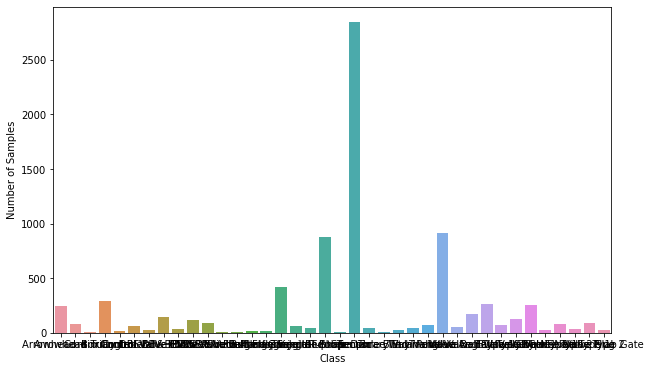

In [27]:
## 1. Load dataset (due to the size of the original repo, we will import it from a cloud location)
data_and_target = pd.read_csv('https://www.dropbox.com/s/sj277k4slmrv3qc/symbols_combined_pixel_red.csv?raw=1',
                             header = None)
data = data_and_target.iloc[:,:-1].values.tolist()
target = data_and_target.iloc[:,-1:].to_numpy().tolist()
target = list(chain.from_iterable(target))

## 2. Find majority and minority classes
majority_class = max(set(target), key=target.count)
minority_class = min(set(target), key=target.count)

## 3. Plot distribution of original dataset
print('Dataset: '+str(dataset))
histo = [['Class','Number of Samples']]
for i, label1 in enumerate(sorted(list(set(target)))):
    cont = 0
    for j, label2 in enumerate(target):
        if label1 == label2:
            cont+=1
    histo.append([label1,cont])
histo.append(['Total Samples', len(target)])

# Load as a panda
histo_panda = pd.DataFrame.from_records(histo[1:-1], columns=histo[0])
print(histo_panda)
print('Total samples: '+str(len(target)))
# Create a histogram using seaborn
sns_plot = sns.barplot(x="Class", y="Number of Samples", data=histo_panda)
# Save the image
sns_plot.figure.set_size_inches(10, 6)
print('\nShowing class distribution bar chart...')
plt.show()

**STEP 2:** Apply class decomposition to the majority class (i.e. Sensors)


Class decomposition by applying k-means...
No clustering performed for class Arrowhead.
No clustering performed for class Arrowhead + Triangle.
No clustering performed for class Box.
No clustering performed for class Continuity Label.
No clustering performed for class Control.
No clustering performed for class Control Valve.
No clustering performed for class Control Valve Globe.
No clustering performed for class DB&BBV.
No clustering performed for class DB&BBV + Valve Check.
No clustering performed for class DB&BPV.
No clustering performed for class ESDV Valve Ball.
No clustering performed for class ESDV Valve Butterfly.
No clustering performed for class ESDV Valve Slab Gate.
No clustering performed for class Exit to Atmosphere.
No clustering performed for class Flange + Triangle.
No clustering performed for class Flange Joint.
No clustering performed for class Flange Single T-Shape.
No clustering performed for class Injector Point.
No clustering performed for class Reducer.
No cluste

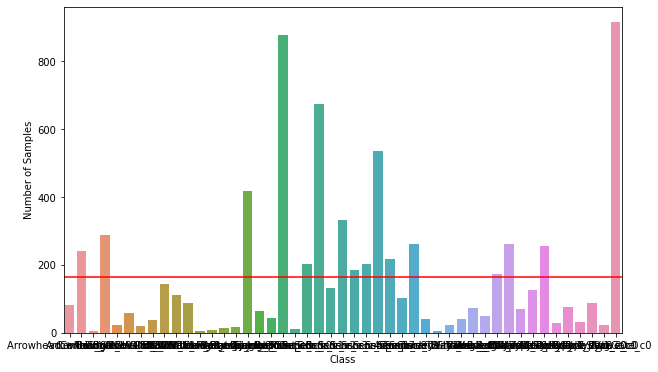

In [28]:
## 1. Calculate k vector (for class decomposition)
k = computeKVs.majority(data, target, n_clusters)

## 2. Cluster the data
if classdecomp.lower()=='kmeans':
    target_cd = clustData.Kmeans(data, target, k)
elif classdecomp.lower()=='fcmeans':
    target_cd = clustData.FCmeans(data, target, k)
elif classdecomp.lower()=='fcmeansoptimised':
     target_cd = clustData.FCmeansOptimised(data, target, k, max_nclusters = 10)   
elif classdecomp.lower()=='dbscan':        
     target_cd = clustData.DBSCAN(data, target, k, eps=0.5, min_samples=5)
else:
    print('Invalid clustering algorithm selected.')
    sys.exit()
    
## 3. Plot distribution after cd
histo = [['Class','Number of Samples']]
for i, label1 in enumerate(sorted(list(set(target_cd)))):
    cont = 0
    for j, label2 in enumerate(target_cd):
        if label1 == label2:
            cont+=1
    histo.append([label1,cont])
histo.append(['Total Samples', len(target_cd)])
# Load as a panda
histo_panda = pd.DataFrame.from_records(histo[1:-1], columns=histo[0])
print(histo_panda)
print('Total samples: '+str(len(target_cd)))
# Create a histogram using seaborn
sns_plot = sns.barplot(x="Class", y="Number of Samples", data=histo_panda)
# draw a line depicting the average
indexesUnique = list(set(target_cd))
indexesUnique.sort()
cdclassdist_count = []
cdclassdist_names = []
for cdclass in indexesUnique:
     cdclassdist_count.append(target_cd.count(cdclass))
     cdclassdist_names.append(cdclass)
average = sum(cdclassdist_count)/len(cdclassdist_count)
print('Average number of samples per class:', average)
plt.axhline(average, color='red')
# Save the image
sns_plot.figure.set_size_inches(10, 6)
print('\nShowing class distribution bar chart...')
plt.show()

**STEP 3:** Apply oversampling to all classes which have `average-threshold` samples or less

Oversampling class Arrowhead + Triangle_c0...
Oversampling class Box_c0...
Oversampling class Control Valve Globe_c0...
Oversampling class Control Valve_c0...
Oversampling class Control_c0...
Oversampling class DB&BBV + Valve Check_c0...
Oversampling class DB&BBV_c0...
Oversampling class DB&BPV_c0...
Oversampling class ESDV Valve Ball_c0...
Oversampling class ESDV Valve Butterfly_c0...
Oversampling class ESDV Valve Slab Gate_c0...
Oversampling class Exit to Atmosphere_c0...
Oversampling class Flange + Triangle_c0...
Oversampling class Flange Single T-Shape_c0...
Oversampling class Injector Point_c0...
Oversampling class Rupture Disc_c0...
Oversampling class Spectacle Blind_c0...
Oversampling class Temporary Strainer_c0...
Oversampling class Three Way Valve_c0...
Oversampling class Tie In Point_c0...
Oversampling class Triangle_c0...
Oversampling class Valve Angle_c0...
Oversampling class Valve Butterfly Type 1_c0...
Oversampling class Valve Check_c0...
Oversampling class Valve Globe Ty

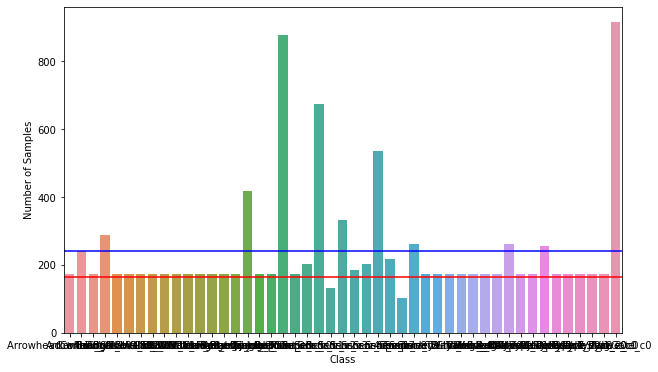

In [29]:
## 1. Calculate reference class (i.e. closest to the average and above it) for oversampling
c = np.inf
ref = majority_class+'_c0' # gets picked by default if none other accomplishes
for i,j in enumerate(cdclassdist_count):
    if abs(j-average)<c and j-average>=0:
        c = abs(j-average)
        ref = cdclassdist_names[i]

data_cdsmote = list(np.asarray(data)[(np.where(np.asarray(target)==majority_class))])
target_cdsmote = list(np.asarray(target_cd)[(np.where(np.asarray(target)==majority_class))])

## 2. For all non-majority classes (considering the original dataset), see if they are far (i.e. difference greater than the threshold) from the average (red line in the last plot)
flag = 0
for i, cdclassdist_name in enumerate(cdclassdist_names):
    if majority_class not in cdclassdist_name.split('_')[0]:
        if abs(average-cdclassdist_count[i])>threshold and average-cdclassdist_count[i]>=0:
            flag = 1
            print('Oversampling class '+str(cdclassdist_name)+'...')            
            ## 3. Create a sub-dataset that only contains the new majority and current non-minority classes
            data_majmin = []
            target_majmin = []
            for j, label in enumerate(target_cd):
                if label == cdclassdist_name or label == ref:
                    data_majmin.append(data[j])
                    target_majmin.append(label)
            ## 4. Do the oversampling
            if oversampler.lower() == 'smote':
                sm = SMOTE()
                data_over, target_over = sm.fit_resample(data_majmin, target_majmin) 
            elif oversampler.lower() == 'adasyn':
                ada = ADASYN()
                data_over, target_over = ada.fit_resample(data_majmin, target_majmin)
            else:
                print('Invalid oversampling algorithm.')
                sys.exit() 
            # Append the oversampled data to the new repository
            for j, label in enumerate(target_over):
                if label == cdclassdist_name:
                    data_cdsmote.append(list(data_over[j]))
                    target_cdsmote.append(label)
        else:
            # Append the not-oversampled
            for j, label in enumerate(target_cd):
                if label == cdclassdist_name:
                    data_cdsmote.append(list(data[j]))
                    target_cdsmote.append(label)
            
    
## 5. Plot distribution after smote
if flag == 1:
    histo = [['Class','Number of Samples']]
    for i, label1 in enumerate(sorted(list(set(target_cdsmote)))):
        cont = 0
        for j, label2 in enumerate(target_cdsmote):
            if label1 == label2:
                cont+=1
        histo.append([label1,cont])
    histo.append(['Total Samples', len(target_cdsmote)])

    ## Load as a panda
    histo_panda = pd.DataFrame.from_records(histo[1:-1], columns=histo[0])
    print(histo_panda)
    print('Total samples: '+str(len(target_cdsmote)))
    ## Create a histogram using seaborn
    sns_plot = sns.barplot(x="Class", y="Number of Samples", data=histo_panda)
    ## draw a line depicting the average
    indexesUnique = list(set(target_cdsmote))
    indexesUnique.sort()
    newestclassdist_count = []
    for newestclass in indexesUnique:
          newestclassdist_count.append(target_cdsmote.count(newestclass))
    average_new = sum(newestclassdist_count)/len(newestclassdist_count)
    print('New average number of samples per class:', average_new)
    plt.axhline(average, color='red')
    plt.axhline(average_new, color='blue')
    ## Save the image
    sns_plot.figure.set_size_inches(10, 6)
    print('\nShowing class distribution bar chart...')
    plt.show()
else:
    print('All non-majority classes are close to average. No oversampling was needed.')

**STEP 4:** Classification (using SVM), comparing the **weighted** *precision*, *recall* and *f1-score* of the original dataset versus the one generated through CDSMOTE. We apply a five fold cross validation.

In [31]:
import warnings; warnings.simplefilter('ignore')
print('\n')

accuracy_o_final = 0
accuracy_c_final = 0
recall_o_final = 0
recall_c_final = 0
precision_o_final = 0
precision_c_final = 0
f1_o_final = 0
f1_c_final = 0

## Split data/target and data_cdsmote/target_cdsmote (stratified and with many splits)
sss = StratifiedShuffleSplit(n_splits=5, 
                             test_size=0.3, random_state=42)

# Original data, only do on the first test for the dataset to save time
experiments = 0
for train_index, test_index in sss.split(data, target):
    # print(train_index, test_index)
    print('\nExperiment '+str(experiments+1)+' Original DB...')
    experiments+=1
    X_train_o, X_test_o = np.asarray(data)[train_index], np.asarray(data)[test_index]
    y_train_o, y_test_o = np.asarray(target)[train_index], np.asarray(target)[test_index]
    clf_o = svm.SVC(kernel='linear')
    clf_o.fit(X_train_o, y_train_o)
    y_pred_o = clf_o.predict(X_test_o)
    # Test         
    print("Precision Original DB:",metrics.precision_score(y_test_o, y_pred_o, average='weighted'))
    print("Recall Original DB:",metrics.recall_score(y_test_o, y_pred_o, average='weighted'))
    print("F1 Score Original DB:",metrics.f1_score(y_test_o, y_pred_o, average='weighted'))
    precision_o_final = precision_o_final + metrics.precision_score(y_test_o, y_pred_o, average='weighted')
    recall_o_final = recall_o_final + metrics.recall_score(y_test_o, y_pred_o, average='weighted')
    f1_o_final = f1_o_final + metrics.f1_score(y_test_o, y_pred_o, average='weighted')

    print('\n------')

# CDSMOTE data
experiments = 0
for train_index, test_index in sss.split(data_cdsmote, target_cdsmote):
    print('\nExperiment '+str(experiments+1)+' CDSMOTE DB...')
    experiments+=1
    X_train_c, X_test_c,  = np.asarray(data_cdsmote)[train_index], np.asarray(data_cdsmote)[test_index]
    y_train_c, y_test_c = np.asarray(target_cdsmote)[train_index], np.asarray(target_cdsmote)[test_index]
    # Train models
    clf_c = svm.SVC(kernel='linear')
    clf_c.fit(X_train_c, y_train_c)
    y_pred_c = clf_c.predict(X_test_c)
    # Test, making sure accuracy considers sub_classes as good
    for i,label in enumerate(y_pred_c):
          y_pred_c[i] = label.split('_')[0]
    for i,label in enumerate(y_test_c):
          y_test_c[i] = label.split('_')[0]
    print("Precision CDSMOTE DB:",metrics.precision_score(y_test_c, y_pred_c, average='weighted'))
    print("Recall CDSMOTE DB:",metrics.recall_score(y_test_c, y_pred_c, average='weighted'))
    print("F1 Score CDSMOTE DB:",metrics.f1_score(y_test_c, y_pred_c, average='weighted'))
    precision_c_final = precision_c_final + metrics.precision_score(y_test_c, y_pred_c, average='weighted')
    recall_c_final = recall_c_final + metrics.recall_score(y_test_c, y_pred_c, average='weighted')
    f1_c_final = f1_c_final + metrics.f1_score(y_test_c, y_pred_c, average='weighted')

print('\n')

# Final results
print('Final Results:')
print("Average Precision Original DB:",precision_o_final/experiments)
print("Average Recall Original DB:",recall_o_final/experiments)
print("Average F1 Score Original DB:",f1_o_final/experiments)
print("Average Precision CDSMOTE DB:",precision_c_final/experiments)
print("Average Recall CDSMOTE DB:",recall_c_final/experiments)
print("Average F1 Score CDSMOTE DB:",f1_c_final/experiments)




Experiment 1 Original DB...
Precision Original DB: 0.9531628073915369
Recall Original DB: 0.9498052790999567
F1 Score Original DB: 0.9476363921022607

------

Experiment 2 Original DB...
Precision Original DB: 0.9564496768110253
Recall Original DB: 0.9528342708784077
F1 Score Original DB: 0.9500074960141541

------

Experiment 3 Original DB...
Precision Original DB: 0.9551737337405147
Recall Original DB: 0.9511034184335785
F1 Score Original DB: 0.9479535909721091

------

Experiment 4 Original DB...


C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision Original DB: 0.9523344049575958
Recall Original DB: 0.9515361315447858
F1 Score Original DB: 0.9484953147318262

------

Experiment 5 Original DB...


C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision Original DB: 0.952431997702874
Recall Original DB: 0.9489398528775422
F1 Score Original DB: 0.9465845978138188

------

Experiment 1 CDSMOTE DB...
Precision CDSMOTE DB: 0.9849239196665214
Recall CDSMOTE DB: 0.9843565525383707
F1 Score CDSMOTE DB: 0.9844701039256643

Experiment 2 CDSMOTE DB...
Precision CDSMOTE DB: 0.984035475085413
Recall CDSMOTE DB: 0.9834710743801653
F1 Score CDSMOTE DB: 0.9835078390070822

Experiment 3 CDSMOTE DB...
Precision CDSMOTE DB: 0.9837109004986501
Recall CDSMOTE DB: 0.9828807556080283
F1 Score CDSMOTE DB: 0.9828984079278923

Experiment 4 CDSMOTE DB...
Precision CDSMOTE DB: 0.9816352704166788
Recall CDSMOTE DB: 0.980814639905549
F1 Score CDSMOTE DB: 0.9809139026778976

Experiment 5 CDSMOTE DB...
Precision CDSMOTE DB: 0.9884028246225326
Recall CDSMOTE DB: 0.9878984651711924
F1 Score CDSMOTE DB: 0.9880021298136578


Final Results:
Average Precision Original DB: 0.9539105241207094
Average Recall Original DB: 0.9508437905668542
Average F1 Score Origina

Notice the the *weighted f1-score* when classifying this dataset increases from 0.94 to 0.98!

In [34]:
import warnings; warnings.simplefilter('ignore')
# Printing the classification report of the fifth experiment of each case
from sklearn.metrics import classification_report
print('\nClassification Report (Original DB)')
print(classification_report(y_test_o, y_pred_o, target_names=list(set(target))))
print('\nClassification Report (CDSMOTE DB)')
print(classification_report(y_test_c, y_pred_c, target_names=list(set(target))))


Classification Report (Original DB)
                        precision    recall  f1-score   support

   Valve Needle Type 1       0.93      0.97      0.95        72
           Valve Angle       0.83      0.76      0.79        25
         Control Valve       1.00      1.00      1.00         2
  DB&BBV + Valve Check       0.90      0.89      0.89        87
  ESDV Valve Butterfly       1.00      0.83      0.91         6
    Valve Globe Type 2       0.94      0.83      0.88        18
                 Valve       1.00      0.29      0.44         7
                DB&BBV       0.90      0.84      0.87        43
                DB&BPV       1.00      0.58      0.74        12
     Valve Ball Type 1       0.97      0.88      0.92        34
Valve Butterfly Type 1       0.91      0.81      0.86        26
    Exit to Atmosphere       0.00      0.00      0.00         2
     Valve Ball Type 2       1.00      1.00      1.00         3
    Temporary Strainer       1.00      1.00      1.00         4
  

Moreover, we can see previously unfavoured classes (i.e. `spectacle blind` or `valve check`) have increased precision and recall respectively, while the majority class (i.e. `sensors`) also has an increased f1-score! 